## Calculating the Road Segment Congestion Index


We want to calculate the Road Segment Congestion Index. For this, we first load the data with the mean speeds per segment and subsequently create an "edge" data frame to obtain the maximum speeds on the relevant edge.

In [2]:
# Imports, options
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import osmnx as ox
import pandas as pd

gpd.options.use_pygeos = True
from config import rpath
os.chdir(rpath)

In [2]:
Rv = pd.read_csv("data/Rv.csv", names = ['edge_id', 'time_id', 'n', 'speed', 'meanspeed'], skiprows=4)
Rv.head()

edge_id  time_id   n  speed  meanspeed
0  100027768-29690836        7  25  231.0   9.240000
1  100027768-29690836        8  26  257.0   9.884615
2  100027768-29690836        9  26  156.0   6.000000
3  100027768-29690836       10  21  400.0  19.047619
4  100027768-29690836       19  17  299.0  17.588235

In [3]:
# Create edge data frame to get speeds from the OSM graph
edges = pd.DataFrame({'edge_id':Rv.edge_id.unique()})
edges[["edge_1", "edge_2"]] = edges["edge_id"].str.split("-", expand=True)
edges["edge_1"] = edges["edge_1"].astype(int)
edges["edge_2"] = edges["edge_2"].astype(int)
edges.head()

edge_id     edge_1      edge_2
0    100027768-29690836  100027768    29690836
1    100032633-29796810  100032633    29796810
2   100032633-433557530  100032633   433557530
3  100069498-1370811846  100069498  1370811846
4   100069498-268224213  100069498   268224213

In [4]:
G = ox.io.load_graphml("data/graphs/berlin-2851.graphml") # 
H = ox.simplification.simplify_graph(ox.io.load_graphml("data/graphs/Berlin-raw.graphml"))

In the following, we extract maxspeeds from the OSM graph. When more than one way id is summarized into one edge, there might be more than one speed indication (that is, a list of speeds). If this is the case, we look at the length of the different OSM ways and take the speed that is valid for the majority of the edge. If the individual OSM ways cannot be found, we take the maximum of the list of speeds. This way, we might run into "type a errors", i.e., identifying "congested" streets when there is no congestion in reality, because "our" max speed is higher than the actual max speed, and hence also higher than the observed speed in some cases. However, this is better than "type b errors", in which case we would observe Road Speed Indices of > 1, making identifying congested roads more improbable.

In [5]:
nomaxspeeds = []
maxSpeeds = []

for i in range(len(edges)): # For every edge
    if (i+1) % 1000 == 0:
        print("Processing", i+1, "of", len(edges), "edges")
    
    # Check conditions that max speed is available in G
    maxspeedyes = 'maxspeed' in G[edges.iloc[i,1]][edges.iloc[i,2]][0]
    speed = None
    
    if maxspeedyes:
        speed = G[edges.iloc[i,1]][edges.iloc[i,2]][0]['maxspeed']
        if speed == "DE:urban":
            speed = 50

    # In case G does not have max speed info, look it up in newer graph
    if speed is None: # If there's no info in geoff's belin graph
        osmids = G[edges.iloc[i,1]][edges.iloc[i,2]][0]['osmid'] # get the individual OSM way IDs
        if type(osmids) == int: # If osmids is not a list but a single integer
            osmids = [osmids] # make it a list so we can loop through
        for oid in osmids: # for every way ID
            speed = None
            for u,v in H.edges(): # loop through all the edges in the unsimplified berlin graph
                if H[u][v][0]["osmid"] == oid: # if we find the way ID
                    if "maxspeed" in H[u][v][0]: # If we find maxspeed in graph
                        print("Found max speed in original graph")
                        speed = H[u][v][0]["maxspeed"]
                        break
                    elif "maxspeed:type" in H[u][v][0]: # If we find maxspeed type in graph
                        speed = H[u][v][0]["maxspeed:type"]
                        print("Found max speed type in original graph:", speed)
                        if speed == "DE:urban":
                            speed = 50
                            break
                        elif speed == "DE:zone30":
                            speed = 30
                            break
                        else:
                            print("ALARMALARM", speed)
                            raise Exception("TEST")
                            
    if speed is None: # If there's still no speed info
        print("Neither maxspeed nor maxspeed type info available for osmid", oid)
        nomaxspeeds.append(oid) 
        maxSpeeds.append(np.nan)
        continue        
            
    if type(speed) == list: # if there is more than one edge speed
        osmids = G[edges.iloc[i,1]][edges.iloc[i,2]][0]['osmid'] # get the individual OSM way IDs
        segmentlengths = []
        speeds = []
        if 'none' in speed: # if 'none' is in the speed list
                idx = speed.index('none') # find the index of the none entry
                speed.pop(idx) # pop the none entry
                speed = [float(x) for x in speed] # convert to float
        for oid in osmids: # for every way ID
            for u,v in H.edges(): # loop through all the edges in the unsimplified berlin graph
                try:
                    if H[u][v][0]["osmid"] == oid: # if we find the way ID
                        if "length" not in H[u][v][0] or "maxspeed" not in H[u][v][0]:
                            continue
                        else:
                            segmentlengths.append(H[u][v][0]["length"]) # get the segment length
                            speeds.append(H[u][v][0]["maxspeed"]) # and segment max speed
                except Exception as e:
                    print("An unknown exception incurred.")
                    print(i)
                    raise e
        if len(segmentlengths) == 0 or len(speeds) == 0: # if no way ID can be found
            speed = max(speed) # take the max speed of the existing speed list
        else:
            speed = (pd.DataFrame({'length':segmentlengths,'speed':speeds}) # Data frame with all segment lengths and speeds
                 .groupby("speed") # group by speeds
                 .agg("sum") # sum over segment lengths
                 .sort_values("length",ascending=False) # sort so that the longest segment is first
                 .index[0]) # get the index (speed) of the first entry (longest segment)
    maxSpeeds.append(speed)

Neither maxspeed nor maxspeed type info available for osmid 25368898
Found max speed type in original graph: DE:urban
Neither maxspeed nor maxspeed type info available for osmid 5116453
Found max speed type in original graph: DE:urban
Neither maxspeed nor maxspeed type info available for osmid 29112676
Neither maxspeed nor maxspeed type info available for osmid 167410411
Neither maxspeed nor maxspeed type info available for osmid 26406925
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 11405545
Neither maxspeed nor maxspeed type info available for osmid 11405545
Neither maxspeed nor maxspeed type info available for osmid 11405545
Neither maxspeed nor maxspeed type info available for osmid 11405545
Neither maxspeed nor maxspeed type info available for osmid 27156341
Neither maxspeed nor maxspeed type info available for osmid 8792775
Neither maxspeed nor maxspeed type info available for osmid 15920080
Neither maxspeed nor maxspeed type info a

Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 128978595
Neither maxspeed nor maxspeed type info available for osmid 128978595
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 154946524
Neither maxspeed nor maxspeed type info available for osmid 154946524
Neither maxspeed nor maxspeed type info available for osmid 154946523
Neither maxspeed nor maxspeed type info available for osmid 131577614
Neither maxspeed nor maxspeed type info available for osmid 131577614
Neither maxspeed nor maxspeed type info available for osmid 19064220
Neither maxspeed nor maxspeed type info available for osmid 19064220
Neither maxspeed nor maxspeed type info available for osmid 82121192
Neither maxspeed nor maxspeed type info available for osmid 82121192
Neither maxspeed nor maxspeed type info available for osmid 14674294
Neither maxspeed nor maxspeed type info available for osmid 211562073
Neither maxspeed nor maxspe

Neither maxspeed nor maxspeed type info available for osmid 16109891
Neither maxspeed nor maxspeed type info available for osmid 149488400
Neither maxspeed nor maxspeed type info available for osmid 149488401
Neither maxspeed nor maxspeed type info available for osmid 149488399
Neither maxspeed nor maxspeed type info available for osmid 149611534
Neither maxspeed nor maxspeed type info available for osmid 149611534
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 4407372
Neither maxspeed nor maxspeed type info available for osmid 4662762
Neither maxspeed nor maxspeed type info available for osmid 25367771
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 40193019
Neither maxspeed nor maxspeed type info available for osmid 151621386

Neither maxspeed nor maxspeed type info available for osmid 172183872
Neither maxspeed nor maxspeed type info available for osmid 172183869
Neither maxspeed nor maxspeed type info available for osmid 172183870
Neither maxspeed nor maxspeed type info available for osmid 172183867
Neither maxspeed nor maxspeed type info available for osmid 172183871
Neither maxspeed nor maxspeed type info available for osmid 172183869
Neither maxspeed nor maxspeed type info available for osmid 23809468
Neither maxspeed nor maxspeed type info available for osmid 192487146
Neither maxspeed nor maxspeed type info available for osmid 25939421
Neither maxspeed nor maxspeed type info available for osmid 26807992
Neither maxspeed nor maxspeed type info available for osmid 176037629
Neither maxspeed nor maxspeed type info available for osmid 172699421
Neither maxspeed nor maxspeed type info available for osmid 175298126
Neither maxspeed nor maxspeed type info available for osmid 43963437
Processing 7000 of 47293

Neither maxspeed nor maxspeed type info available for osmid 166974626
Found max speed type in original graph: DE:urban
Neither maxspeed nor maxspeed type info available for osmid 156066238
Neither maxspeed nor maxspeed type info available for osmid 708515798
Neither maxspeed nor maxspeed type info available for osmid 149611534
Neither maxspeed nor maxspeed type info available for osmid 228635045
Neither maxspeed nor maxspeed type info available for osmid 228635045
Neither maxspeed nor maxspeed type info available for osmid 228635046
Neither maxspeed nor maxspeed type info available for osmid 148326359
Neither maxspeed nor maxspeed type info available for osmid 135403248
Neither maxspeed nor maxspeed type info available for osmid 135403248
Neither maxspeed nor maxspeed type info available for osmid 229475732
Neither maxspeed nor maxspeed type info available for osmid 229475750
Neither maxspeed nor maxspeed type info available for osmid 229475761
Neither maxspeed nor maxspeed type info a

Neither maxspeed nor maxspeed type info available for osmid 23382150
Neither maxspeed nor maxspeed type info available for osmid 24036553
Neither maxspeed nor maxspeed type info available for osmid 24036305
Neither maxspeed nor maxspeed type info available for osmid 23382150
Neither maxspeed nor maxspeed type info available for osmid 24036305
Neither maxspeed nor maxspeed type info available for osmid 23382155
Neither maxspeed nor maxspeed type info available for osmid 23389632
Neither maxspeed nor maxspeed type info available for osmid 23389632
Neither maxspeed nor maxspeed type info available for osmid 23389943
Found max speed type in original graph: DE:urban
Neither maxspeed nor maxspeed type info available for osmid 23409834
Found max speed type in original graph: DE:urban
Neither maxspeed nor maxspeed type info available for osmid 23409831
Neither maxspeed nor maxspeed type info available for osmid 23409834
Neither maxspeed nor maxspeed type info available for osmid 23409831
Neith

Neither maxspeed nor maxspeed type info available for osmid 841401763
Neither maxspeed nor maxspeed type info available for osmid 24204363
Neither maxspeed nor maxspeed type info available for osmid 24204426
Neither maxspeed nor maxspeed type info available for osmid 24204426
Neither maxspeed nor maxspeed type info available for osmid 24204432
Neither maxspeed nor maxspeed type info available for osmid 24204437
Neither maxspeed nor maxspeed type info available for osmid 24204439
Neither maxspeed nor maxspeed type info available for osmid 24204443
Neither maxspeed nor maxspeed type info available for osmid 24204623
Neither maxspeed nor maxspeed type info available for osmid 24204678
Neither maxspeed nor maxspeed type info available for osmid 31521784
Neither maxspeed nor maxspeed type info available for osmid 31521784
Neither maxspeed nor maxspeed type info available for osmid 31521784
Neither maxspeed nor maxspeed type info available for osmid 151465254
Neither maxspeed nor maxspeed ty

Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 489521492
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 489521492
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Neither maxspeed nor maxspeed type info avai

Neither maxspeed nor maxspeed type info available for osmid 49810638
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 828836631
Neither maxspeed nor maxspeed type info available for osmid 828836631
Neither maxspeed nor maxspeed type info available for osmid 14369669
Neither maxspeed nor maxspeed type info available for osmid 14369553
Found max speed in original graph
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 24695140
Neither maxspeed nor maxspeed type info available for osmid 24695140
Neither maxspeed nor maxspeed type info available for osmid 191377893
Neither maxspeed nor maxspeed type info available for osmid 160120060
Neither maxspeed nor maxspeed type info available for osmid 100405511
Neither maxspeed nor maxspeed type info available for osmid 101290100
Neither maxspeed nor maxspeed type info available for osmid 101290100
Neither maxspeed nor maxspeed type info available for osmid 814

Neither maxspeed nor maxspeed type info available for osmid 482983238
Neither maxspeed nor maxspeed type info available for osmid 62312775
Neither maxspeed nor maxspeed type info available for osmid 69126512
Processing 21000 of 47293 edges
Neither maxspeed nor maxspeed type info available for osmid 454285423
Neither maxspeed nor maxspeed type info available for osmid 151457956
Neither maxspeed nor maxspeed type info available for osmid 152863274
Neither maxspeed nor maxspeed type info available for osmid 25199006
Neither maxspeed nor maxspeed type info available for osmid 645343613
Neither maxspeed nor maxspeed type info available for osmid 4484149
Neither maxspeed nor maxspeed type info available for osmid 28012464
Neither maxspeed nor maxspeed type info available for osmid 207412830
Neither maxspeed nor maxspeed type info available for osmid 22913804
Processing 22000 of 47293 edges
Neither maxspeed nor maxspeed type info available for osmid 111531489
Neither maxspeed nor maxspeed typ

Neither maxspeed nor maxspeed type info available for osmid 25368898
Neither maxspeed nor maxspeed type info available for osmid 25368898
Neither maxspeed nor maxspeed type info available for osmid 220943169
Neither maxspeed nor maxspeed type info available for osmid 220943169
Neither maxspeed nor maxspeed type info available for osmid 166974626
Neither maxspeed nor maxspeed type info available for osmid 166973638
Neither maxspeed nor maxspeed type info available for osmid 166973638
Neither maxspeed nor maxspeed type info available for osmid 25367771
Neither maxspeed nor maxspeed type info available for osmid 41350279
Neither maxspeed nor maxspeed type info available for osmid 41350236
Neither maxspeed nor maxspeed type info available for osmid 41350236
Neither maxspeed nor maxspeed type info available for osmid 41350236
Neither maxspeed nor maxspeed type info available for osmid 41350307
Neither maxspeed nor maxspeed type info available for osmid 590230774
Neither maxspeed nor maxspee

Neither maxspeed nor maxspeed type info available for osmid 24250804
Neither maxspeed nor maxspeed type info available for osmid 51260521
Found max speed type in original graph: DE:urban
Found max speed type in original graph: DE:urban
Neither maxspeed nor maxspeed type info available for osmid 26236567
Neither maxspeed nor maxspeed type info available for osmid 26236564
Neither maxspeed nor maxspeed type info available for osmid 26236556
Found max speed in original graph
Found max speed in original graph
Found max speed type in original graph: DE:urban
Found max speed type in original graph: DE:urban
Neither maxspeed nor maxspeed type info available for osmid 391407797
Neither maxspeed nor maxspeed type info available for osmid 4696063
Neither maxspeed nor maxspeed type info available for osmid 26269149
Neither maxspeed nor maxspeed type info available for osmid 26269149
Neither maxspeed nor maxspeed type info available for osmid 4797951
Found max speed type in original graph: DE:urba

Neither maxspeed nor maxspeed type info available for osmid 4638298
Neither maxspeed nor maxspeed type info available for osmid 622614662
Neither maxspeed nor maxspeed type info available for osmid 4637898
Neither maxspeed nor maxspeed type info available for osmid 762502634
Neither maxspeed nor maxspeed type info available for osmid 4637808
Neither maxspeed nor maxspeed type info available for osmid 370617829
Neither maxspeed nor maxspeed type info available for osmid 23368773
Neither maxspeed nor maxspeed type info available for osmid 24591982
Neither maxspeed nor maxspeed type info available for osmid 26938217
Neither maxspeed nor maxspeed type info available for osmid 42997865
Neither maxspeed nor maxspeed type info available for osmid 26180781
Neither maxspeed nor maxspeed type info available for osmid 30958679
Neither maxspeed nor maxspeed type info available for osmid 26180781
Found max speed type in original graph: DE:urban
Found max speed type in original graph: DE:urban
Neith

Found max speed type in original graph: DE:urban
Found max speed type in original graph: DE:urban
Neither maxspeed nor maxspeed type info available for osmid 32446831
Found max speed type in original graph: DE:urban
Found max speed type in original graph: DE:urban
Neither maxspeed nor maxspeed type info available for osmid 25797635
Neither maxspeed nor maxspeed type info available for osmid 470350077
Neither maxspeed nor maxspeed type info available for osmid 32446831
Neither maxspeed nor maxspeed type info available for osmid 25797635
Neither maxspeed nor maxspeed type info available for osmid 198585468
Neither maxspeed nor maxspeed type info available for osmid 385402821
Neither maxspeed nor maxspeed type info available for osmid 470350077
Neither maxspeed nor maxspeed type info available for osmid 385402821
Processing 31000 of 47293 edges
Neither maxspeed nor maxspeed type info available for osmid 31024362
Neither maxspeed nor maxspeed type info available for osmid 27168761
Found ma

Neither maxspeed nor maxspeed type info available for osmid 4777119
Found max speed in original graph
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 4777119
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed type in original graph: DE:urban
Found max speed type in original graph: DE:urban
Found max speed type in original graph: DE:urban
Neither maxspeed nor maxspeed type info available for osmid 45904914
Neither maxspeed nor maxspeed type info available for osmid 142062866
Neither maxspeed nor maxspeed type info available for osmid 142063347
Neither maxspeed nor maxspeed type info available for osmid 142062901
Neither maxspeed nor maxspeed type info available for osmid 142063347
Neither maxspeed nor maxspeed type info available for osmid 142062866
Neither maxspeed nor maxspeed type info available for osmid 142062866
Neither maxspeed nor max

Neither maxspeed nor maxspeed type info available for osmid 52608377
Neither maxspeed nor maxspeed type info available for osmid 156597542
Neither maxspeed nor maxspeed type info available for osmid 39349389
Neither maxspeed nor maxspeed type info available for osmid 39349389
Neither maxspeed nor maxspeed type info available for osmid 176037630
Neither maxspeed nor maxspeed type info available for osmid 176037630
Neither maxspeed nor maxspeed type info available for osmid 176037630
Neither maxspeed nor maxspeed type info available for osmid 28281357
Neither maxspeed nor maxspeed type info available for osmid 137728457
Neither maxspeed nor maxspeed type info available for osmid 147717027
Neither maxspeed nor maxspeed type info available for osmid 28113423
Neither maxspeed nor maxspeed type info available for osmid 120853582
Neither maxspeed nor maxspeed type info available for osmid 5559338
Neither maxspeed nor maxspeed type info available for osmid 766001206
Neither maxspeed nor maxspe

Neither maxspeed nor maxspeed type info available for osmid 30100915
Neither maxspeed nor maxspeed type info available for osmid 4556357
Neither maxspeed nor maxspeed type info available for osmid 4556356
Neither maxspeed nor maxspeed type info available for osmid 4553268
Neither maxspeed nor maxspeed type info available for osmid 30100927
Neither maxspeed nor maxspeed type info available for osmid 57686461
Neither maxspeed nor maxspeed type info available for osmid 24028197
Neither maxspeed nor maxspeed type info available for osmid 24028197
Neither maxspeed nor maxspeed type info available for osmid 24028197
Neither maxspeed nor maxspeed type info available for osmid 24028197
Neither maxspeed nor maxspeed type info available for osmid 24028197
Neither maxspeed nor maxspeed type info available for osmid 24028197
Neither maxspeed nor maxspeed type info available for osmid 24028197
Neither maxspeed nor maxspeed type info available for osmid 24028197
Neither maxspeed nor maxspeed type in

Neither maxspeed nor maxspeed type info available for osmid 5077357
Neither maxspeed nor maxspeed type info available for osmid 5077373
Neither maxspeed nor maxspeed type info available for osmid 52524384
Neither maxspeed nor maxspeed type info available for osmid 41800868
Neither maxspeed nor maxspeed type info available for osmid 5077373
Neither maxspeed nor maxspeed type info available for osmid 65968492
Found max speed in original graph
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 4615782
Neither maxspeed nor maxspeed type info available for osmid 5095302
Neither maxspeed nor maxspeed type info available for osmid 5095372
Neither maxspeed nor maxspeed type info available for osmid 500229567
Neither maxspeed nor maxspeed type info available for osmid 696354580
Neither maxspeed nor maxspeed type info available for osmid 5096381
Neither maxspeed nor maxspeed type info available for osmid 5096537
Neither maxspeed nor maxspeed type info a

Neither maxspeed nor maxspeed type info available for osmid 25939421
Neither maxspeed nor maxspeed type info available for osmid 35779809
Neither maxspeed nor maxspeed type info available for osmid 35779861
Neither maxspeed nor maxspeed type info available for osmid 24209429
Neither maxspeed nor maxspeed type info available for osmid 23410057
Neither maxspeed nor maxspeed type info available for osmid 52513361
Neither maxspeed nor maxspeed type info available for osmid 881155133
Found max speed type in original graph: DE:urban
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Found max speed type in original graph: DE:urban
Neither maxspeed nor maxspeed type info available for osmid 220943169
Neither maxspeed nor maxspeed type info available for osmid 155605357
Neither maxspeed nor maxspeed type info available for osmid 36969682
Neith

Neither maxspeed nor maxspeed type info available for osmid 138459744
Neither maxspeed nor maxspeed type info available for osmid 39514494
Neither maxspeed nor maxspeed type info available for osmid 41340056
Neither maxspeed nor maxspeed type info available for osmid 41340056
Neither maxspeed nor maxspeed type info available for osmid 41350307
Neither maxspeed nor maxspeed type info available for osmid 41340056
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 41399045
Neither maxspeed nor maxspeed type info available for osmid 161755128
Neither maxspeed nor maxspeed type info available for osmid 205799205
Neither maxspeed nor maxspeed type info available for osmid 520386245
Neither maxspeed nor maxspeed type info available for osmid 520386246
Neither maxspeed nor maxspeed type info available for osmid 520386247
Neither maxspeed nor maxspeed type info available for osmid 5203

Neither maxspeed nor maxspeed type info available for osmid 609943358
Neither maxspeed nor maxspeed type info available for osmid 609943359
Neither maxspeed nor maxspeed type info available for osmid 612040247
Neither maxspeed nor maxspeed type info available for osmid 616670793
Neither maxspeed nor maxspeed type info available for osmid 614573217
Neither maxspeed nor maxspeed type info available for osmid 614862910
Neither maxspeed nor maxspeed type info available for osmid 614862920
Neither maxspeed nor maxspeed type info available for osmid 614862913
Found max speed in original graph
Found max speed in original graph
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 618339167
Neither maxspeed nor maxspeed type info available for osmid 618924838
Neither maxspeed nor maxspeed type info available for osmid 671122316
Neither maxspeed nor maxspeed type info available for osmid 618924838
Neither maxspeed nor maxspeed type info available for osmi

Neither maxspeed nor maxspeed type info available for osmid 51038803
Neither maxspeed nor maxspeed type info available for osmid 31099803
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 31099803
Neither maxspeed nor maxspeed type info available for osmid 51038804
Neither maxspeed nor maxspeed type info available for osmid 51069314
Neither maxspeed nor maxspeed type info available for osmid 694745015
Neither maxspeed nor maxspeed type info available for osmid 751604618
Neither maxspeed nor maxspeed type info available for osmid 27156341
Neither maxspeed nor maxspeed type info available for osmid 494999974
Neither maxspeed nor maxspeed type info available for osmid 131834976
Neither maxspeed nor maxspeed type info available for osmid 4592581
Neither maxspeed nor maxspeed type info available for osmid 51807954
Neither maxspeed nor maxspeed type info available for osmid 51807954
Neither maxspeed nor maxspeed type info available for osmid 703963

Neither maxspeed nor maxspeed type info available for osmid 268341946
Neither maxspeed nor maxspeed type info available for osmid 857503740
Neither maxspeed nor maxspeed type info available for osmid 857503740
Neither maxspeed nor maxspeed type info available for osmid 331318343
Neither maxspeed nor maxspeed type info available for osmid 331318343
Found max speed in original graph
Neither maxspeed nor maxspeed type info available for osmid 31759808
Neither maxspeed nor maxspeed type info available for osmid 532198758
Neither maxspeed nor maxspeed type info available for osmid 532198758
Neither maxspeed nor maxspeed type info available for osmid 532198758
Neither maxspeed nor maxspeed type info available for osmid 254493283
Neither maxspeed nor maxspeed type info available for osmid 9659868
Neither maxspeed nor maxspeed type info available for osmid 60728013
Neither maxspeed nor maxspeed type info available for osmid 60728013
Found max speed in original graph
Found max speed in original

Neither maxspeed nor maxspeed type info available for osmid 11009143
Neither maxspeed nor maxspeed type info available for osmid 34104006
Neither maxspeed nor maxspeed type info available for osmid 34104006
Neither maxspeed nor maxspeed type info available for osmid 11009167
Neither maxspeed nor maxspeed type info available for osmid 11009167
Neither maxspeed nor maxspeed type info available for osmid 11009167
Neither maxspeed nor maxspeed type info available for osmid 11027581
Neither maxspeed nor maxspeed type info available for osmid 11027581
Neither maxspeed nor maxspeed type info available for osmid 145486354
Neither maxspeed nor maxspeed type info available for osmid 11027581
Neither maxspeed nor maxspeed type info available for osmid 11025158
Neither maxspeed nor maxspeed type info available for osmid 11025158
Neither maxspeed nor maxspeed type info available for osmid 11025429
Neither maxspeed nor maxspeed type info available for osmid 11025429
Neither maxspeed nor maxspeed typ

In [6]:
# Convert maxSpeeds to numeric (includes some string artifacts)
print(np.unique(maxSpeeds))
edges["maxSpeed"] = pd.to_numeric(maxSpeeds, errors='coerce')
print("Road Segments without max speed:",
      round((edges.maxSpeed.isna().sum()/len(edges))*100,2), "%")
print("Number of considered edge segments:", len(edges))
edges.head()

['10' '100' '120' '120.0' '15' '20' '30' '40' '5' '50' '60' '7' '70' '80'
 'nan' 'walk']
Road Segments without max speed: 4.95 %
Number of considered edge segments: 47293


edge_id     edge_1      edge_2  maxSpeed
0    100027768-29690836  100027768    29690836      30.0
1    100032633-29796810  100032633    29796810      50.0
2   100032633-433557530  100032633   433557530      50.0
3  100069498-1370811846  100069498  1370811846      30.0
4   100069498-268224213  100069498   268224213      30.0

In [7]:
# Merge above df with Rv data and get actual Rv
Rv = Rv.merge(edges, on="edge_id")
Rv = Rv.dropna(subset=["maxSpeed"]) # Drop rows with NaN
Rv.loc[:,"Rv"] = (Rv["meanspeed"]/Rv["maxSpeed"])
Rv.loc[Rv.Rv > 1, "Rv"] = 1  # Avoid artifacts where Rv > 1 because of wrong road speed info

Now, we have the *speed performance index*:
$$
R_v = \frac{v}{V_{max}}\times 100
$$
for edge segments with more than 20 observations in the given time windows. What follows is that we assign the road status based on the thresholds as they were used in the corresponding article (He et al., 2016).

In [8]:
# Add road segment status for each time
conditions = [
    (Rv.Rv < .25),
    ((Rv.Rv > .25) & (Rv.Rv <= .50)),
    ((Rv.Rv > .50) & (Rv.Rv <= .75)),
    (Rv.Rv > .75)
]

values = ["Heavy Congestion", "Mild Congestion", "Smooth", "Very Smooth"]
Rv['status'] = np.select(conditions, values) 

Here, we add a "T" variable which corresponds to T_t from the article. It is the total number of time periods for each edge segment.

In [14]:
Rv_status = Rv.merge((Rv[["edge_id", "time_id"]]
                      .groupby("edge_id")
                      .agg("count")), on="edge_id").rename(columns={"time_id_y": "T", "time_id_x": "time_id"})

In [15]:
Rv_status.head()

edge_id  time_id   n  speed  meanspeed     edge_1    edge_2  \
0  100027768-29690836        7  25  231.0   9.240000  100027768  29690836   
1  100027768-29690836        8  26  257.0   9.884615  100027768  29690836   
2  100027768-29690836        9  26  156.0   6.000000  100027768  29690836   
3  100027768-29690836       10  21  400.0  19.047619  100027768  29690836   
4  100027768-29690836       19  17  299.0  17.588235  100027768  29690836   

   maxSpeed        Rv            status  T  
0      30.0  0.308000   Mild Congestion  8  
1      30.0  0.329487   Mild Congestion  8  
2      30.0  0.200000  Heavy Congestion  8  
3      30.0  0.634921            Smooth  8  
4      30.0  0.586275            Smooth  8

In the following, we drop all rows that do not have data for the full 40 time periods. We can see below that these correspond to more than 50% of the data (median = 40). Furthermore, we would expect the most critical road segments to have data for all segments during the peak hours. Then, we calculate $R_{NC}$ from the article and add it to the data frame for each edge id. 

In [16]:
print(np.quantile(Rv_status.drop_duplicates(subset="edge_id")["T"], np.arange(0,1,.1)))
T_med = np.median(Rv_status.drop_duplicates(subset="edge_id")["T"])
print("Median:", T_med)
print("Number of observations with less than",
      T_med,
      "observation periods within the rush hour window:", 
      len(Rv_status[Rv_status["T"] < T_med].edge_id.unique()))
print("In percent: ", len(Rv_status[Rv_status["T"] < T_med].edge_id.unique())/len(edges))
      
Rv_status = Rv_status[Rv_status["T"] >= T_med] # drop T < T_med

[ 1.  2.  5. 12. 24. 34. 39. 40. 40. 40.]
Median: 34.0
Number of observations with less than 34.0 observation periods within the rush hour window: 21900
In percent:  0.46307064470429027


In [17]:
# Add R_NC
Rv_status = Rv_status.merge(
    (Rv_status[["edge_id", "status"]]
     .groupby('edge_id')
     .status
     .apply(lambda x: ((x == 'Smooth') | (x == "Very Smooth")).mean())),
    on = "edge_id"
).rename(columns={'status_x':'status', 'status_y':'R_NC'})
Rv_status.head()

edge_id  time_id    n   speed  meanspeed     edge_1    edge_2  \
0  100032633-29796810        0   64  1762.0  27.531250  100032633  29796810   
1  100032633-29796810        1  101  2250.0  22.277228  100032633  29796810   
2  100032633-29796810        2   99  2092.0  21.131313  100032633  29796810   
3  100032633-29796810        3  121  2666.0  22.033058  100032633  29796810   
4  100032633-29796810        4  126  2463.0  19.547619  100032633  29796810   

   maxSpeed        Rv           status   T   R_NC  
0      50.0  0.550625           Smooth  40  0.125  
1      50.0  0.445545  Mild Congestion  40  0.125  
2      50.0  0.422626  Mild Congestion  40  0.125  
3      50.0  0.440661  Mild Congestion  40  0.125  
4      50.0  0.390952  Mild Congestion  40  0.125

Finally, we calculate the Road Segment Congestion Index $R_i = R_v\cdot R_{NC}$

In [21]:
# Calculate R_i
RSI = Rv_status[["edge_id", "R_NC", "Rv", "maxSpeed"]].groupby(["edge_id", "R_NC", "maxSpeed"]).agg("mean")
RSI = RSI.reset_index(level=['R_NC', "maxSpeed"])
RSI.loc[:,"RSI"] = RSI.R_NC*RSI.Rv
RSI = RSI.sort_values("RSI")
RSI = RSI.reset_index(level="edge_id")
RSI[["edge_1", "edge_2"]] = RSI.edge_id.str.split("-", expand=True)
RSI["edge_1"] = RSI.edge_1.astype(int)
RSI["edge_2"] = RSI.edge_2.astype(int)
RSI = RSI.set_index("edge_id")
print(RSI.head())
print("We have the RSI for", len(RSI), "segments.")
print("In percent, this is", len(RSI)/len(edges),".")

                      R_NC  maxSpeed        Rv  RSI      edge_1     edge_2
edge_id                                                                   
1641539234-262404417   0.0      50.0  0.302947  0.0  1641539234  262404417
31259334-31259335      0.0      50.0  0.359555  0.0    31259334   31259335
27432048-27432050      0.0      50.0  0.399031  0.0    27432048   27432050
16541467-16541468      0.0      50.0  0.381496  0.0    16541467   16541468
31259132-31259331      0.0      50.0  0.360298  0.0    31259132   31259331
We have the RSI for 23053 segments.
In percent, this is 0.4874505740807308 .


In [22]:
# Print out the "top 10" congested road segments
x = []
for i in range(10):
    e1, e2 = RSI.index[i].split("-")
    e1, e2 = int(e1), int(e2)
    x.append(G[e1][e2])
    print(G[e1][e2])

{0: {'osmid': 121758998, 'oneway': True, 'lanes': '3', 'ref': 'L 751', 'name': 'Altglienicker Chaussee', 'highway': 'secondary', 'maxspeed': '50', 'length': 41.254, 'geometry': <shapely.geometry.linestring.LineString object at 0x2acc0079ab50>, 'grade': 0.048, 'grade_abs': 0.048}}
{0: {'osmid': 165984239, 'name': 'Saalestraße', 'highway': 'residential', 'maxspeed': '50', 'oneway': False, 'length': 8.871, 'grade': 0.0, 'grade_abs': 0.0}}
{0: {'osmid': 874511375, 'name': 'Klingsorstraße', 'highway': 'tertiary', 'maxspeed': '50', 'oneway': False, 'length': 79.665, 'geometry': <shapely.geometry.linestring.LineString object at 0x2acbf0850d90>, 'grade': -0.013, 'grade_abs': 0.013}}
{0: {'osmid': [165006276, 415288173], 'oneway': True, 'lanes': ['4', '3'], 'name': 'Reichsstraße', 'highway': 'secondary', 'maxspeed': '50', 'length': 44.67, 'geometry': <shapely.geometry.linestring.LineString object at 0x2acc03010d90>, 'grade': -0.045, 'grade_abs': 0.045}}
{0: {'osmid': [813606313, 865078174, 8650

In [23]:
# And we save it
RSI.to_csv("data/RSI2.csv")

## Plot
Plotting the road segments colored by their RSI

In [ ]:
# Alternative 1: Use get_edge_colors_by_attr
RSI = pd.read_csv("data/RSI2.csv", index_col=0)
# Add attribute to edge in graph
for u, v in G.edges():
    u, 
    for i in G[u][v]:
        if str(u)+"-"+str(v) in RSI.index:
            G[u][v][i]["RSI"] = RSI.loc[str(u)+"-"+str(v), "RSI"] 
        else:
            G[u][v][i]["RSI"] = np.nan
            
# Get edge colors in two versions (application depends on background: black or white)
ec_light = ox.plot.get_edge_colors_by_attr(G, 'RSI', equal_size=True, cmap="RdYlGn", na_color="#eeeeee", num_bins=10)
ec_dark = ox.plot.get_edge_colors_by_attr(G, 'RSI', equal_size=True, cmap="RdYlGn", na_color="#666666", num_bins=10)

# Plot
fig, ax = ox.plot_graph(G, node_color='w', node_size=0, 
                        edge_color=ec_dark,
                        edge_linewidth=1, figsize=(14,14), bgcolor="black")

In [ ]:
# Alternative 2
ev = [RSI[RSI.index == str(u) + "-" + str(v)]["RSI"][0] if str(u) + "-" + str(v) in RSI.index else np.nan for u, v in G.edges() ]
# create a color scale converted to list of colors for graph edges
norm = mcolors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) if not np.isnan(cl) else '#666666' for cl in ev]

# color the edges in the original graph by closeness centrality in line graph
fig, ax = ox.plot_graph(G, node_color='w', node_size=0, 
                        edge_color=ec,
                        edge_linewidth=1, figsize=(14,14), bgcolor="black")

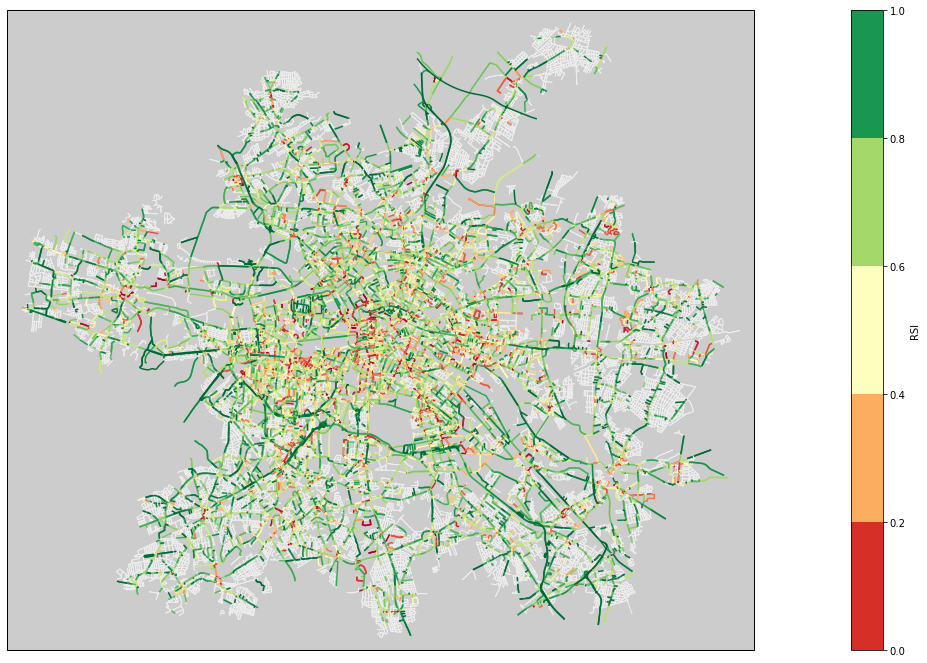

In [91]:
# Alternative 3: Use the GeoDataFrame of the graph

# Retrieve nodes and edges
nodes, edges = ox.graph_to_gdfs(G)
edges.reset_index(inplace=True)


# Plot the edges
a = RSI.merge(edges, left_on=["edge_1", "edge_2"], right_on=["u","v"])
a['color'] = a.RSI_y.apply(lambda x: plt.cm.RdYlGn(x))
a = gpd.GeoDataFrame(a, geometry=a.geometry).set_crs(4326)

# Plot the streets
fig, ax = ox.plot_graph(G, figsize=(20,20), close=False, show=False, node_color='w', 
                        node_size=0,edge_linewidth=1, edge_color="#eeeeee")

# Plot 
a.plot(ax=ax, color=a['color'])

# Colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

# Get the color for the colorbar
cmap = cm.RdYlGn
norm = mcolors.Normalize(vmin=a.RSI_y.min(), vmax=a.RSI_y.max())

# for making the colorbar the right size
aspect = 20
divider = make_axes_locatable(ax)
width = axes_size.AxesY(ax, aspect=1./aspect)
cax = divider.append_axes("right", size=width, pad=-2)


fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, 
             orientation='vertical', label='RSI', 
             boundaries = np.arange(0,1,.2).tolist()+[1])

ax.set_facecolor('#cccccc')
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1') 
plt.show()